K-Means performance evaluation

CIFAR-10

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from time import time
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import torch

np.random.seed(0)

def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_cifar10_data(data_dir, negatives=False):
    # label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    meta_data_dict = unpickle(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []


    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))

    cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.uint8)
    cifar_train_labels = np.array(cifar_train_labels)


    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.uint8)

    #cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)

    return cifar_train_data, cifar_train_labels, cifar_test_data, cifar_test_labels

def flatten_data(x):
    samples = x.shape[0]
    flattened_shape = 1
    for dim in x.shape[1:]:
        flattened_shape *= dim
    return x.reshape(samples, flattened_shape)

def generate_kmeans_model(X, k):
    kmeans = KMeans(n_clusters=k, random_state=0)
    transformed = kmeans.fit_predict(X)
    return kmeans, transformed

def pca_encode(pca_model, X):
    return pca_model.transform(X)

def pca_decode(pca_model, X):
    return pca_model.inverse_transform(X)

def clusters_to_index(cluster_labels):
    dict = {}
    for i in range(len(cluster_labels)):
        if cluster_labels[i] in dict:
            dict[cluster_labels[i]].append(i)
        else:
            dict[cluster_labels[i]] = [i]
    return dict

# reconstruct data from N*3072 to N*32*32*3
def construct_image_from_flattern(x, colored = True):
    samples = x.shape[0]
    if colored:
      return x.reshape(samples, 32, 32, 3).astype("uint8")
    else:
      return x.reshape(samples, 32, 32).astype("uint8")

#visualize image data, displayed on row*col grid, x's 1st-dim >= (row*col)
def visualize_data(x, n, ncol, plt_size):
    nrow = n // ncol + 1
    #fig, axes1 = plt.subplots(nrows=nrow, ncols=ncol)
    plt.figure(figsize=(plt_size, plt_size))
    for i in range(n):
        #if i == n: break
        plt.subplot(nrow, ncol, i+1)
        plt.axis("off")
        plt.imshow(x[i])
        #axes1[k].set_axis_off()
        #axes1[k].imshow(x[k])
    plt.tight_layout()
    plt.show()
    return
    
# visualizing kmeans cluster centers
def visualize_kmeans_centre(kmeans_model, pca_model, n, ncol, colored = True):
    cluster_centers = kmeans_model.cluster_centers_
    cluster_centers_decoded = pca_decode(pca_model, cluster_centers)
    cluster_centers_decoded_image = construct_image_from_flattern(cluster_centers_decoded, colored)
    visualize_data(cluster_centers_decoded_image, n, ncol, 15)

def elbow_method(data, n_range, method='inertia'):
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    for k in n_range:
        # Building and fitting the model
        km = KMeans(n_clusters=k).fit(data)
        km.fit(data)
    
        distort = sum(np.min(cdist(data, km.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0]
        distortions.append(distort)
        inertias.append(km.inertia_)
    
        mapping1[k] = sum(np.min(cdist(data, km.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0]
        mapping2[k] = km.inertia_

    if method == 'inertia':
        plt.plot(n_range, inertias, 'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Inertia')
        plt.title('The Elbow Method using Inertia')
        plt.show()
    elif method == 'distortion':
        plt.plot(n_range, distortions, 'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Distortion')
        plt.title('The Elbow Method using Distortion')
        plt.show()
    else:
        raise ValueError("Method not supported")


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    #estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    kmeans_model = kmeans.fit(data)
    fit_time = time() - t0
    #results = [name, fit_time, kmeans_model.inertia_]
    results = [name, fit_time]
    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        #metrics.homogeneity_score,
        #metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.normalized_mutual_info_score,
    ]
    results += [m(labels, kmeans_model.labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            kmeans_model.labels_,
            metric="euclidean",
            #sample_size=300,
        ),
        metrics.calinski_harabasz_score(data, kmeans_model.labels_)
    ]

    return kmeans_model, results

def select_data(data, labels, class_of_interest, class_size):

    n = len(class_of_interest)
    
    arr_size = int(n*class_size)
    print(arr_size)
    data_new = np.empty((arr_size, *data[0].shape))
    labels_new = np.empty((arr_size, ))

    #data_sel = np.empty((0, *data[0].shape))
    #label_sel = np.empty((0, ))
    for i in range(n):
        indices = np.argwhere(labels == class_of_interest[i]).squeeze()
        indices = indices[:class_size]
        #indices = np.random.permutation(indices)[:class_size]

        data_new[i*class_size : (i+1)*class_size] = (data[indices] / 255).astype(np.float)
        labels_new[i*class_size : (i+1)*class_size] = labels[indices].astype(np.uint8)

    np.random.seed(0)
    indices_new = np.random.permutation(arr_size)
    data_new = data_new[indices_new]
    labels_new = labels_new[indices_new]

    return data_new, labels_new
    # for i, (img, label) in enumerate(zip(data, labels)):



2000
(2000, 32, 32, 3)
(2000,)


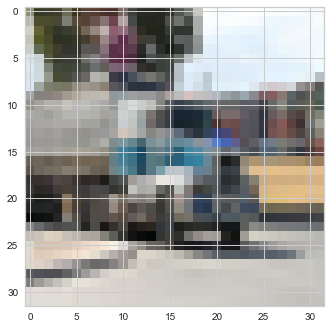

(2000, 3072)


In [9]:
cifar_10_dir = './data/cifar-10-batches-py'
# load data
train_data, train_labels, test_data, test_labels = load_cifar10_data(cifar_10_dir)
X, y = select_data(train_data, train_labels, class_of_interest=[1, 7, 8, 9], class_size=500)
print(X.shape)
print(y.shape)
plt.imshow(X[100])
plt.show()
 
# flatten data

X_flat = flatten_data(X)
print(X_flat.shape)

In [85]:
CIFAR10DataVal = np.load('CIFARValData.npz')['arr_0']

data = []
labels = []
for classno, classimg in enumerate(CIFAR10DataVal):
    for i in range(len(classimg)):
        data.append(classimg[i]/255)
        labels.append(classno)
X = np.array(data)
y = np.array(labels)

print(X.shape)
print(y.shape)
 
# flatten data

X_flat = flatten_data(X)
print(X_flat.shape)

(2000, 32, 32, 3)
(2000,)
(2000, 3072)


In [86]:
from Siamese import CNN
import os
# for emb_size in [1, 5]

def load_SNN(vec_size, run):
    net = CNN(embSize=vec_size)
    path = os.path.join('models', f'siameseArchEmb{str(vec_size)}Run{str(run)}.pth')
    net = torch.load(path)
    net.eval()
    return net

def get_SNN_vec(net, X):
    # Siamese Feature Vector
    feature_vec = []
    for i in range(X.shape[0]):
        img = torch.from_numpy(X[i].transpose(2, 0, 1)).type(torch.FloatTensor)
        out = torch.squeeze(net(img)).detach().numpy()
        feature_vec.append(out)

    feature_vec = np.array(feature_vec)
    #print(feature_vec.shape)
    return feature_vec

Feature vector size:  5
Feature vector size:  10
Feature vector size:  20
Feature vector size:  50


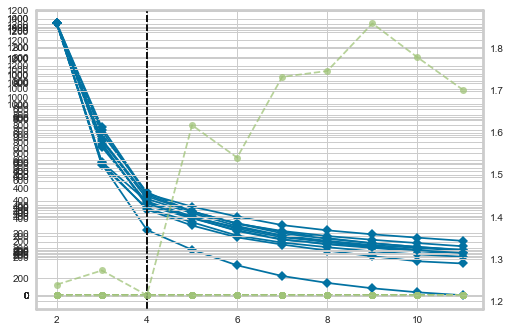

In [87]:
from yellowbrick.cluster import KElbowVisualizer

# #PCA
# feature_vector_size = 50
# pca_model = PCA(n_components=feature_vector_size).fit(test_vec)
# encoded = pca_model.transform(test_vec)
# print(encoded.shape)

# test for optimal k using elbow plot
# elbow method 
elbow_scores = []
scores = []
ks = np.arange(2, 12)
for vec_size in [5, 10, 20, 50]:
    elbow_score = []
    avgs = np.zeros(10)
    for run in [1, 2, 3]:
        SNN = load_SNN(vec_size, run)
        X_vec = get_SNN_vec(SNN, X)
        model = KMeans()
        visualizer1 = KElbowVisualizer(model, k=(2,12))
        #visualizer2 = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz')
        visualizer1.fit(X_vec)        # Fit the data to the visualizer
        avgs += visualizer1.k_scores_
        elbow_score.append(visualizer1.elbow_value_)

    elbow_scores.append(elbow_score)
    score = avgs/3
    scores.append(score)
    print("Feature vector size: ", vec_size)

        # visualizer1.show()        # Finalize and render the figure
        # visualizer2.fit(X_vec)        
        # visualizer2.show()        

In [88]:
votes = []
for score in elbow_scores:
    votes.append(np.argmax(np.bincount(score)))

In [89]:
elbow_scores

[[4, 4, 4], [4, 4, 4], [4, 4, 4], [4, 4, 4]]

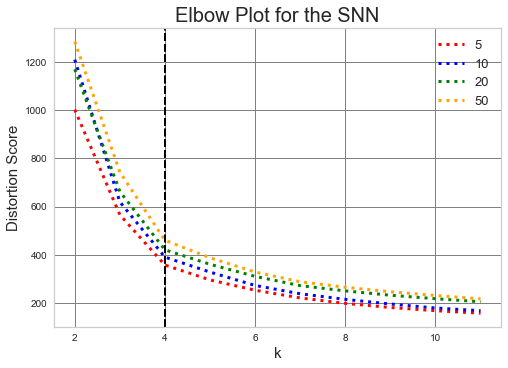

In [139]:
c = ['red', 'blue', 'green', 'orange']


# change the edge color (bluish and transparentish) and thickness
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.yaxis.grid(color='gray')
ax.xaxis.grid(color='gray')


ks = np.arange(2, 12)
vec_sizes = [5, 10, 20, 50]
for i in range(len(scores)):
    ax.plot(ks, scores[i], label=str(vec_sizes[i]), ls='dotted', lw=3, c=c[i])
    ax.axvline(x = votes[i], ls='--', lw=2, c='black')
# ax.set_facecolor([.5,.5,.8,.3])
ax.legend(fontsize=13)
ax.set_title('Elbow Plot for the SNN', fontsize=20)
ax.set_xlabel('k', fontsize=15)
ax.set_ylabel('Distortion Score', fontsize=15)
plt.savefig('imgs/ElbowSNN.png')

In [75]:
votes

[4, 4, 4, 4]

In [82]:
print("\nEvaluating Siamese ...")
print(100 * "_")
#print("init\t\ttime\tinertia\t\thomo\tcompl\tv-meas\tARI\tNMI\tsilhouette\tcalinski\tdavies")
print("init\t\ttime\tv-meas\tARI\tNMI\tsilhouette\tcalinski")

for config in [(5, 4), (10, 4), (20, 4), (50, 4)]:
    metric_list = np.zeros(6)
    for run in [1, 2, 3]:
        feature_vector_size = config[0]
        n_clusters = config[1]

        SNN = load_SNN(feature_vector_size, run)
        X_vec = get_SNN_vec(SNN, X)
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        kmeans_siamese, result = bench_k_means(kmeans, name="SNN-" + "n" + str(n_clusters) + "v" + str(feature_vector_size), data=X_vec, labels=y)
        metric_list += result[1:]
    
    metric_list = list(metric_list/3)
    # Show the results
    formatter_result = (
        #"{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t{:.3f}"
        "{:9s}\t{:.3f}s\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}"
    )
    print(formatter_result.format(*[result[0], *metric_list]))
print(100 * "_")


Evaluating Siamese ...
____________________________________________________________________________________________________
init		time	v-meas	ARI	NMI	silhouette	calinski
SNN-n4v5 	0.730s	0.498	0.466	0.498	0.483		5352.536
SNN-n4v10	0.735s	0.509	0.486	0.509	0.492		5794.780
SNN-n4v20	0.810s	0.502	0.475	0.502	0.464		4593.720
SNN-n4v50	0.799s	0.521	0.495	0.521	0.475		4602.127
____________________________________________________________________________________________________


<h1>Evaluation</h1>

In [83]:
CIFAR10DataVal = np.load('CIFARDataTest.npz')['arr_0']

data = []
labels = []
for classno, classimg in enumerate(CIFAR10DataVal):
    for i in range(len(classimg)):
        data.append(classimg[i]/255)
        labels.append(classno)
X = np.array(data)
y = np.array(labels)

print(X.shape)
print(y.shape)
 
# flatten data

X_flat = flatten_data(X)
print(X_flat.shape)

(4000, 32, 32, 3)
(4000,)
(4000, 3072)


In [84]:
metric_list = np.zeros(6)
print(100 * "_")
print("init\t\ttime\tv-meas\tARI\tNMI\tsilhouette\tcalinski")

for run in [1, 2, 3]:
    feature_vector_size = 50
    n_clusters = 4

    SNN = load_SNN(feature_vector_size, run)
    X_vec = get_SNN_vec(SNN, X)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans_siamese, result = bench_k_means(kmeans, name="SNN-" + "n" + str(n_clusters) + "v" + str(feature_vector_size), data=X_vec, labels=y)
    metric_list += result[1:]

metric_list = list(metric_list/3)
# Show the results
formatter_result = (
    #"{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t{:.3f}"
    "{:9s}\t{:.3f}s\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}"
)
print(formatter_result.format(*[result[0], *metric_list]))
print(100 * "_")

____________________________________________________________________________________________________
init		time	v-meas	ARI	NMI	silhouette	calinski
SNN-n4v50	0.802s	0.521	0.495	0.521	0.475		4602.127
____________________________________________________________________________________________________


<h1>Experiment 2</h1>

In [81]:
metric_list = np.zeros(6)
print(100 * "_")
print("init\t\ttime\tv-meas\tARI\tNMI\tsilhouette\tcalinski")

for run in [1, 2, 3]:
    feature_vector_size = 50
    n_clusters = 4

    SNN = load_SNN(feature_vector_size, run)
    X_vec = get_SNN_vec(SNN, X)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans_siamese, result = bench_k_means(kmeans, name="SNN-" + "n" + str(n_clusters) + "v" + str(feature_vector_size), data=X_vec, labels=y)
    metric_list += result[1:]

metric_list = list(metric_list/3)
# Show the results
formatter_result = (
    #"{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}\t{:.3f}"
    "{:9s}\t{:.3f}s\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t\t{:.3f}"
)
print(formatter_result.format(*[result[0], *metric_list]))
print(100 * "_")

____________________________________________________________________________________________________
init		time	v-meas	ARI	NMI	silhouette	calinski
SNN-n4v50	0.792s	0.521	0.495	0.521	0.475		4602.127
____________________________________________________________________________________________________


0


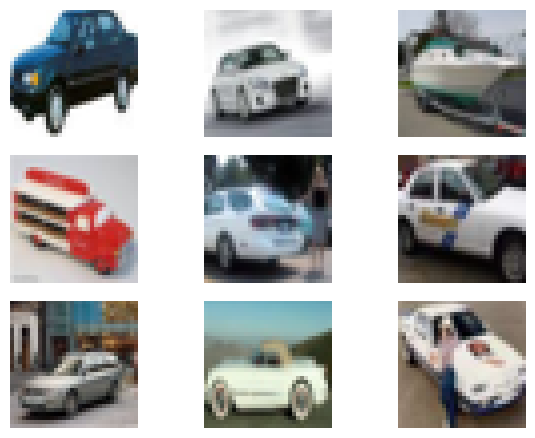

1


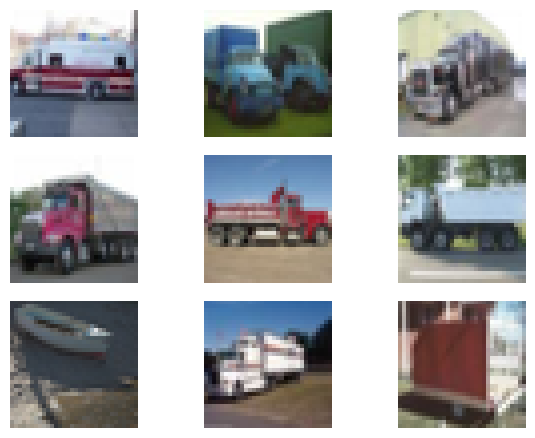

2


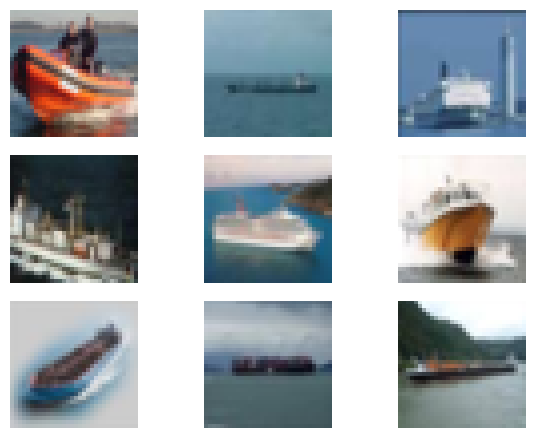

3


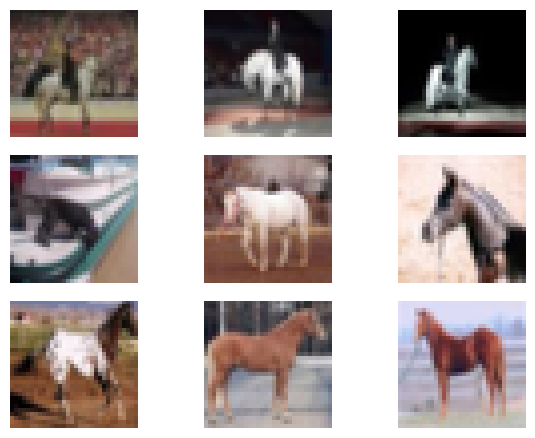

In [143]:
# siamese
kmeans = KMeans(n_clusters=4, random_state=0)
SNN = load_SNN(vec_size=20)
X_vec = get_SNN_vec(SNN, X)
kmeans_siamese = kmeans.fit(X_vec)

# visualize
cluster_index_dict = clusters_to_index(kmeans_siamese.labels_)
for cluster in sorted(list(cluster_index_dict.keys())):
    print(cluster)
    image_index = cluster_index_dict[cluster]
    images = X[image_index]
    visualize_data(images, n=9, ncol=3, plt_size=6)